In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder, MNIST
from torchvision import transforms
from torch import autograd
import numpy as np

In [2]:
class Generator(nn.Module):
    def __init__(self):

        super(Generator, self).__init__()

        self.model = nn.Sequential(                                                         # B 1 28 14
                                   
            torch.nn.Conv2d(1, 32, 3, stride = 1, padding = (3, 2)),                        # B 32 32 16
            torch.nn.LeakyReLU(0.2, inplace = True),
            torch.nn.Conv2d(32, 32, 3, stride = 1, padding = 1),                            # B 32 32 16
            torch.nn.LeakyReLU(0.2, inplace = True),
            torch.nn.MaxPool2d(2, stride = 2, padding = 0),                                 # B 32 16 8

            torch.nn.Conv2d(32, 64, 3, stride = 1, padding = 1),                            # B 64 16 8
            torch.nn.LeakyReLU(0.2, inplace = 0.2),
            torch.nn.Conv2d(64, 64, 3, stride = 1, padding = 1),                            # B 64 16 8
            torch.nn.LeakyReLU(0.2, inplace = True),
            torch.nn.MaxPool2d(2, stride = 2, padding = 0),                                 # B 64 8 4
            
            torch.nn.Conv2d(64, 128, 3, stride = 1, padding = 1),                           # B 128 8 4   
            torch.nn.LeakyReLU(0.2, inplace = True),
            torch.nn.MaxPool2d(2, stride = 2, padding = 0),                                 # B 128 8 4
            torch.nn.LeakyReLU(0.2, inplace = True),

            torch.nn.Conv2d(128, 256, 3, stride = 1, padding = (1, 3)),                     # B 256 8 8
            torch.nn.LeakyReLU(0.2, inplace = True),
            torch.nn.MaxPool2d(2, stride = 2, padding = 0),                                 # B 256 4 4
            torch.nn.LeakyReLU(0.2, inplace = True),  

            torch.nn.MaxPool2d(2, stride = 2, padding = 0),                                 # B 256 2 2
            torch.nn.LeakyReLU(0.2, inplace = True),           
        )    
        
        self.decider = torch.nn.Sequential(
            torch.nn.Dropout(0.2),
            torch.nn.Linear(256, 128),                                                      # B 128
            torch.nn.LeakyReLU(),
        )


        self.sequential_transpose = nn.Sequential( # B 128 2 1
            torch.nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2, padding = 0),    # B 64 4 2    
            torch.nn.LeakyReLU(),
            torch.nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2, padding = 0),     # B 64 8 4
            torch.nn.LeakyReLU(),
            torch.nn.ConvTranspose2d(32, 32, kernel_size = 2, stride = 2, padding = 0),     # B 32 16 8
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 32, kernel_size = 3, stride = 1, padding = 1),              # B 32 16 8
            torch.nn.Dropout(0.2),
            torch.nn.ConvTranspose2d(32, 16, kernel_size = 2, stride = 2, padding = 0),     # B 16 32 16
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(16, 16, kernel_size = 3, stride = 1, padding = 0), # B 8 30 14
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(16, 1, kernel_size = 3, stride = 1, padding = (0, 1)), # B 8 28 14
            torch.nn.Dropout(0.1),
            torch.nn.ReLU(),
        )

        self.lin = torch.nn.Linear(100, 128)

    def unsqueeze(self, input):
        half = torch.unsqueeze(input, 2)
        return torch.unsqueeze(half, 2)
    
    def forward(self, left, noise):
        out = self.model(left)
        out = self.decider(out.flatten(1))
        out = self.unsqueeze(out)
        noise = self.lin(noise.flatten(1))
        noise =self.unsqueeze(noise)
        gen_out = torch.cat([out, noise], 2)
        picture = self.sequential_transpose(gen_out)
        return picture.clamp(0, 255)



In [3]:
class Discriminator(nn.Module):
    def __init__(self):

        super(Discriminator, self).__init__()

        self.model = nn.Sequential(                                                         # B 1 28 28
                                   
            torch.nn.Conv2d(1, 32, 3, stride = 1, padding = 3),                             # B 32 32 32
            torch.nn.LeakyReLU(0.2, inplace = True),
            torch.nn.MaxPool2d(2, stride = 2, padding = 0),                                 # B 32 16 16

            torch.nn.Conv2d(32, 64, 3, stride = 1, padding = 1),                            # B 64 16 16
            torch.nn.LeakyReLU(0.2, inplace = 0.2),
            torch.nn.Conv2d(64, 64, 3, stride = 1, padding = 1),                            # B 64 16 16
            torch.nn.LeakyReLU(0.2, inplace = True),
            torch.nn.MaxPool2d(2, stride = 2, padding = 0),                                 # B 64 8 8
            
            torch.nn.Conv2d(64, 128, 3, stride = 1, padding = 1),                           # B 128 16 16  
            torch.nn.LeakyReLU(0.2, inplace = True),
            torch.nn.Conv2d(128, 128, 3, stride = 1, padding = 1),                          # B 128 16 16
            torch.nn.LeakyReLU(0.2, inplace = True),
            torch.nn.MaxPool2d(2, stride = 2, padding = 0),                                 # B 128 8 8
            torch.nn.LeakyReLU(0.2, inplace = True),

            torch.nn.Conv2d(128, 256, 3, stride = 1, padding = 1),                          # B 256 8 8
            torch.nn.LeakyReLU(0.2, inplace = True),
            torch.nn.MaxPool2d(2, stride = 2, padding = 0),                                 # B 256 4 4
            torch.nn.LeakyReLU(0.2, inplace = True),  

            torch.nn.MaxPool2d(2, stride = 2, padding = 0),                                 # B 256 2 2
            torch.nn.LeakyReLU(0.2, inplace = True),           
        )   

        self.decider = torch.nn.Sequential(
            torch.nn.Dropout(0.2),
            torch.nn.Linear(256, 128),                                                      # B 128
            torch.nn.LeakyReLU(),
            torch.nn.Linear(128, 1),                                                      # B 1
            torch.nn.Sigmoid()
        )

    def forward(self, pictures):
        if len(pictures.shape) == 3:
            pictures = pictures.unsqueeze(1)
        features = self.model(pictures)
        out = self.decider(features.flatten(1))
        out = out.squeeze()
        return out




In [4]:
batch_size = 64

In [5]:
array = torch.zeros((batch_size, 1, 28, 14))
noise_example = torch.zeros((batch_size, 100, 1, 1))

In [6]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

In [7]:
x = mnist.data
y = mnist.target
print(type(y))
print(x.shape)

<class 'numpy.ndarray'>
(70000, 784)


In [8]:
x = x.reshape((70000, 28, 28))

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 17)
x_train, x_val, y_train, y_val =  train_test_split(x_train, y_train, test_size=0.2, random_state=40)
print('%d train, %d validation, %d test data' % (len(x_train), len(x_val), len(x_test)))

39200 train, 9800 validation, 21000 test data


In [11]:
def concat_left_and_right(correct_left, gen_out):
    pictures = torch.cat([correct_left, gen_out], 2)
    return pictures

In [12]:
def generator_trainer(generator, discriminator, b_images, gen_optimizer, criterion, device):    
    
    gen_optimizer.zero_grad()
    B = b_images.shape[0]

    noise = torch.randn(B, 100, 1, 1).to(device, non_blocking=True)
    images = torch.tensor(b_images).to(device, non_blocking=True)

    left = images[:, :, :, :14]                                       # B 28  14
    right = images[:, :, :, 14:]                                      # B 28  14

    fake_right = generator(left, noise)                                 # B 28  14
    validity = discriminator(torch.cat((left, fake_right), dim = 3))     # B

    g_loss = criterion(validity, torch.ones(B).to(device))
    g_loss.backward()
    
    gen_optimizer.step()
    return g_loss

In [13]:
def discriminator_trainer(criterion, discriminator, right_pic, device):    
    
    length = right_pic.shape[0]
    real_images = (right_pic[:length // 2]).to(device)
    fake_images = (right_pic[length // 2:]).to(device)

    noise = torch.randn(fake_images.shape[0], 100, 1, 1, device=torch.device('cuda:0'))
    left = fake_images[:, :, :, :14]
    with torch.no_grad():
        fake_right = generator(left, noise).detach()
    generated_images = torch.cat((left, fake_right), dim=3).to(device)                     # B/2   28  28

    discriminator_inputs = torch.cat((real_images, generated_images), dim=0)   # B     28  28
    ones = torch.ones(real_images.shape[0], device=torch.device('cuda:0'))
    zeros = torch.zeros(generated_images.shape[0], device=torch.device('cuda:0'))
    expect = torch.cat([ones, zeros], dim=0)   # B

    dis_out = discriminator(discriminator_inputs)
    d_loss = criterion(dis_out, expect).to(device) 
    d_loss.backward()

    dis_optimizer.step()
    dis_optimizer.zero_grad()

    return (d_loss)


In [14]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [15]:
epochs = 50

In [16]:
train_loss = np.zeros((epochs,))

In [17]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


In [18]:
gen_optimizer = torch.optim.Adam(filter(
    lambda p : p.requires_grad, generator.parameters()),
    lr = 0.001
)

In [19]:
dis_optimizer = torch.optim.Adam(filter(
    lambda p : p.requires_grad, discriminator.parameters()),
    lr = 0.001
)

In [20]:
from time import time

In [21]:
print(x_train.shape)

(39200, 28, 28)


In [22]:
x_train = np.expand_dims(x_train, axis=1)
print(x_train.shape)

(39200, 1, 28, 28)


In [23]:
x_train = torch.Tensor(x_train)

In [24]:
x_val = np.expand_dims(x_val, axis=1)
x_val.shape

(9800, 1, 28, 28)

In [25]:
x_val = torch.Tensor(x_val)

In [26]:
import matplotlib.pyplot as plt

def draw(images, texts, columns=1, rows=1):
    fig = plt.figure(figsize=(2 * columns, 2 * rows))

    for i in range(columns * rows):
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.set_title(texts[i])
        ax.set_aspect('equal')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(images[i].reshape((28, 28)))

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.set_frame_on(False)
    plt.show()

In [27]:
def draw2(images, texts, columns=1, rows=1):
    fig = plt.figure(figsize=(2 * columns, 2 * rows))

    for i in range(columns * rows):
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.set_title(texts[i])
        ax.set_aspect('equal')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(images[i].reshape((28, 14)))

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.set_frame_on(False)
    plt.show()

In [28]:
def display(generator, x_val, columns, rows):

    inds = np.arange(len(x_val))
    np.random.shuffle(inds)

    batch_inds = inds[:min(len(inds), columns * rows)]

    with torch.no_grad():
        generator.eval()

        batch = x_val[batch_inds]
        z = torch.randn(columns * rows, 100, 1, 1, device=torch.device('cuda:0'))
        batch_images = batch.to(device)
        left = batch_images[:, :, :, :14]
        right = generator(left, z).detach()
        generated_images = torch.cat((left, right), dim=3).cpu().numpy()      # row*col   28  28
        
        images_to_show = np.zeros((rows * columns, 2, 1, 28, 28))
        images_to_show[:,0] = batch
        images_to_show[:,1] = generated_images
        images_to_show = images_to_show.reshape(rows * columns * 2, 28, 28)

        texts = np.zeros((rows * columns, 2), dtype=object)
        texts[:,0] = np.array(['real' for _ in range(rows * columns)])
        texts[:,1] = np.array(['generated' for _ in range(rows * columns)])
        texts = texts.reshape(rows * columns * 2)

        #draw2(right.cpu().numpy(), texts, columns , rows)
        draw(images_to_show, texts, columns * 2, rows)

In [29]:
criterion = torch.nn.BCELoss().to(device)

batch size is: 64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Discriminator Loss: 1.3773e+02 and generator loss is: 1.3581e+02
Epoch 0 ended in 6.14 secs.


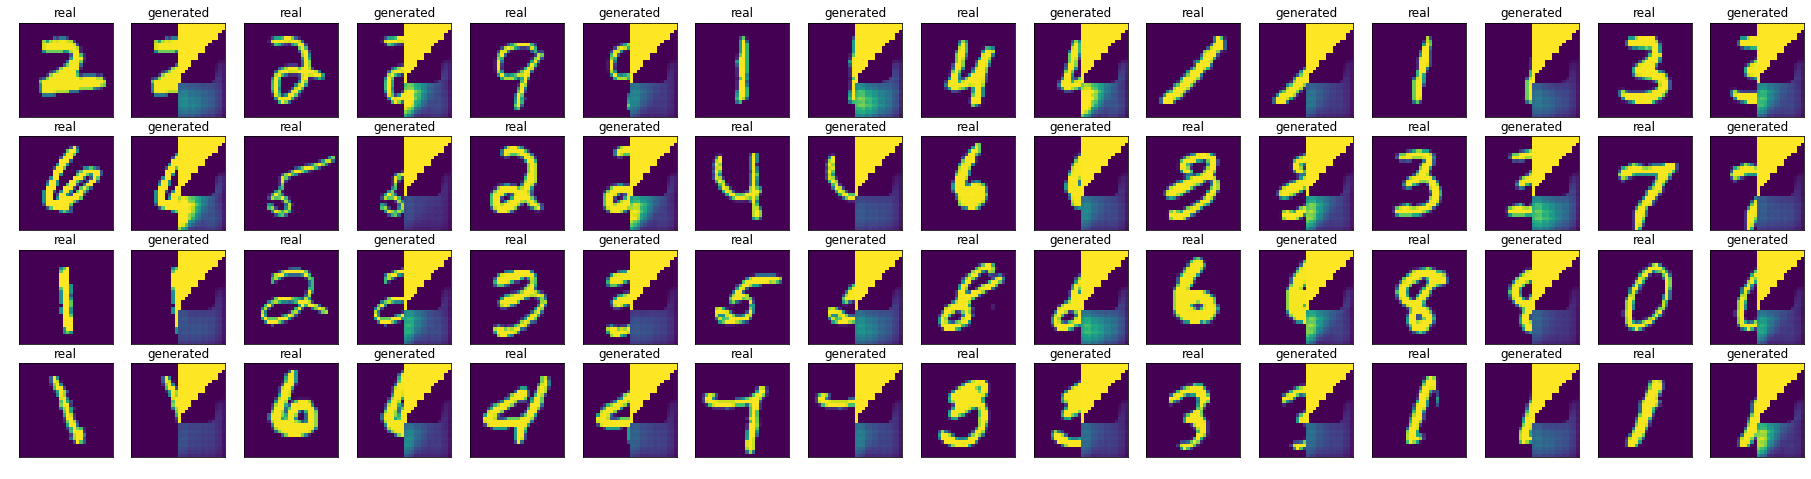

batch size is: 64
Discriminator Loss: 1.2195e+02 and generator loss is: 1.3777e+02
Epoch 1 ended in 6.05 secs.


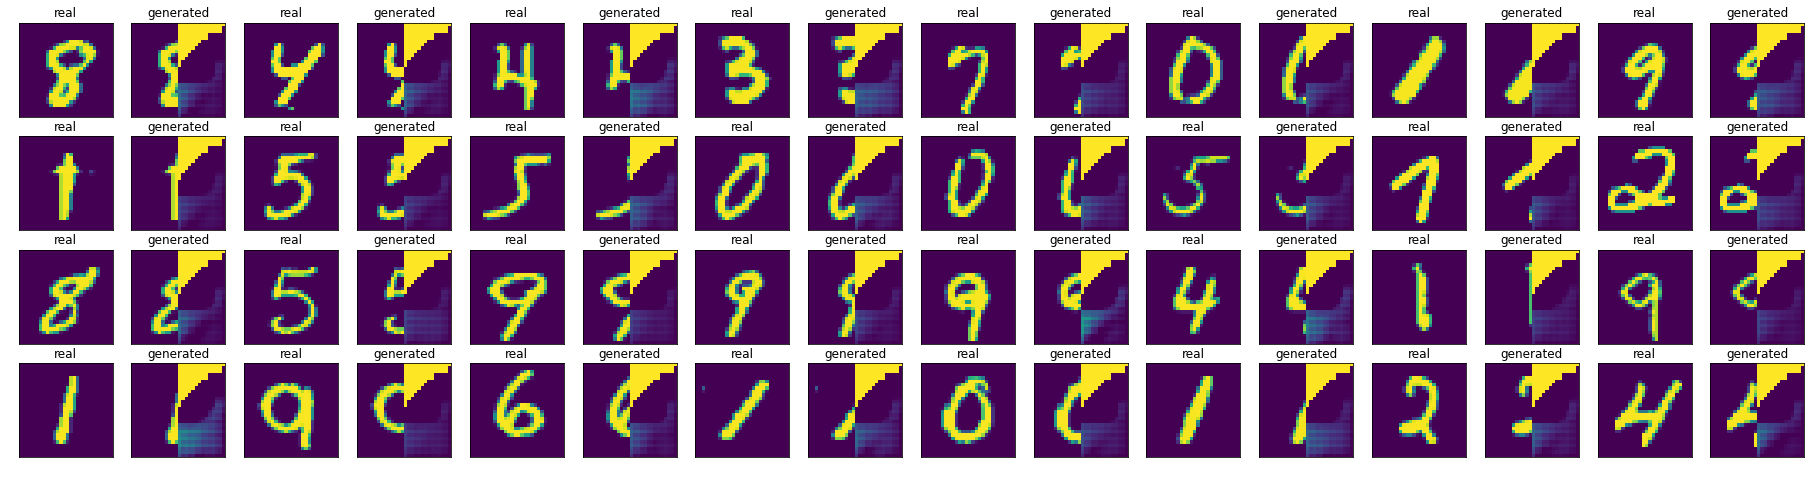

batch size is: 64
Discriminator Loss: 1.2149e+02 and generator loss is: 1.3793e+02
Epoch 2 ended in 6.10 secs.


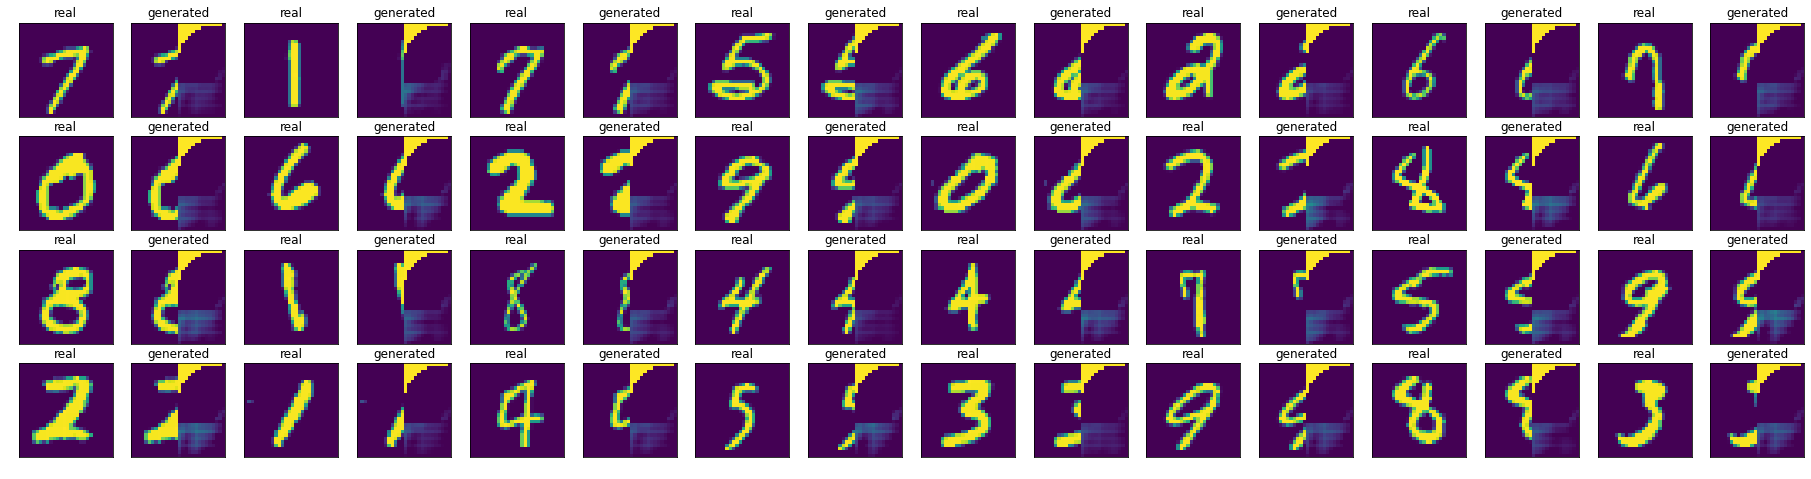

batch size is: 64
Discriminator Loss: 1.2121e+02 and generator loss is: 1.3812e+02
Epoch 3 ended in 6.14 secs.


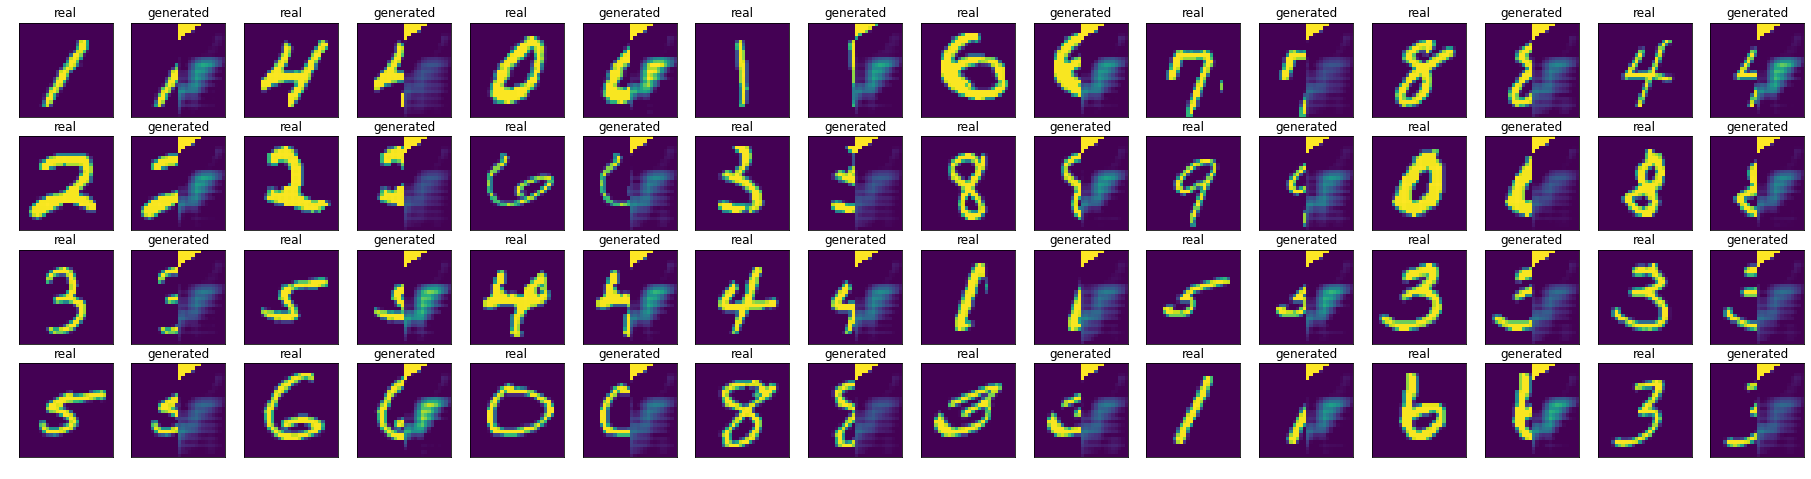

batch size is: 64
Discriminator Loss: 1.9387e+02 and generator loss is: 1.4054e+02
Epoch 4 ended in 6.17 secs.


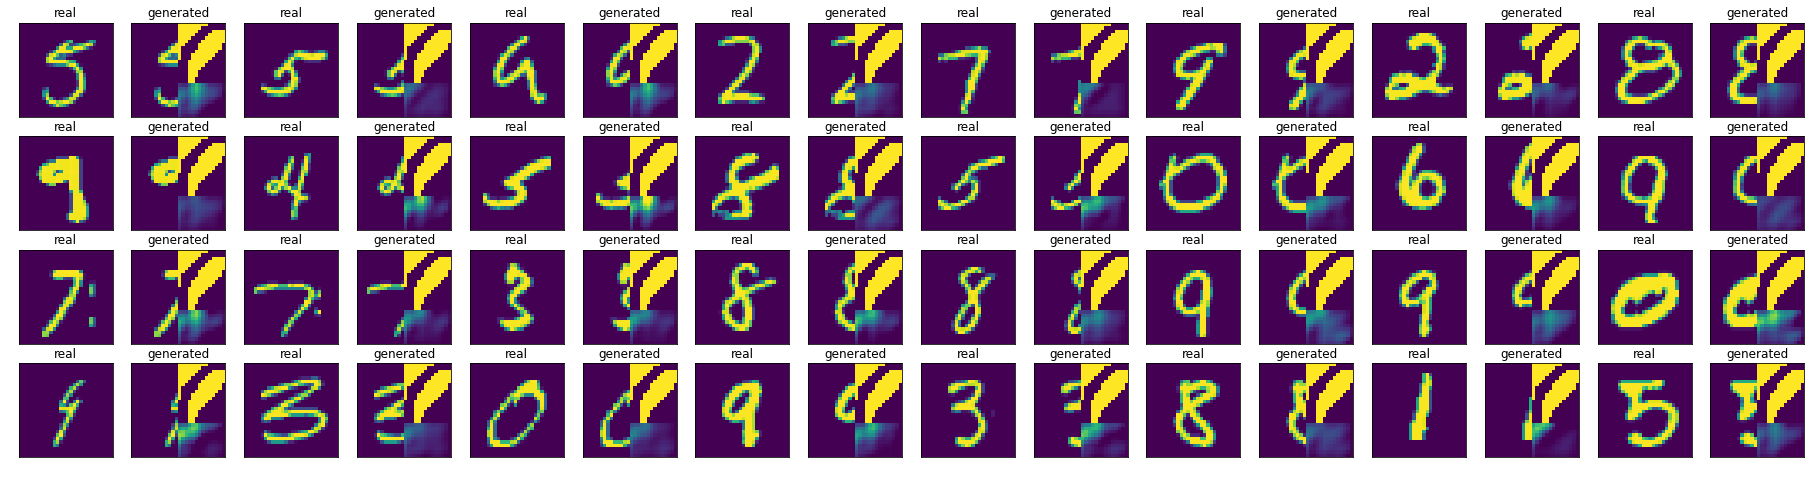

batch size is: 64
Discriminator Loss: 1.1993e+02 and generator loss is: 1.3972e+02
Epoch 5 ended in 6.16 secs.


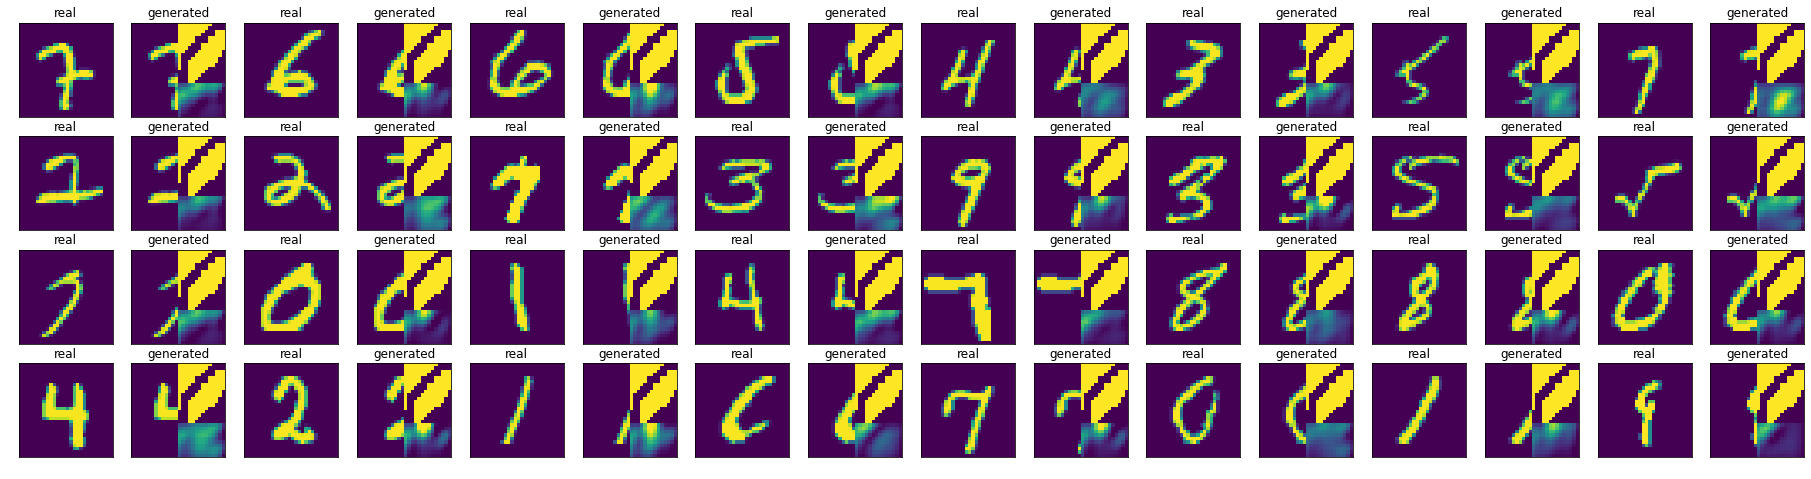

batch size is: 64
Discriminator Loss: 1.2026e+02 and generator loss is: 1.3893e+02
Epoch 6 ended in 6.15 secs.


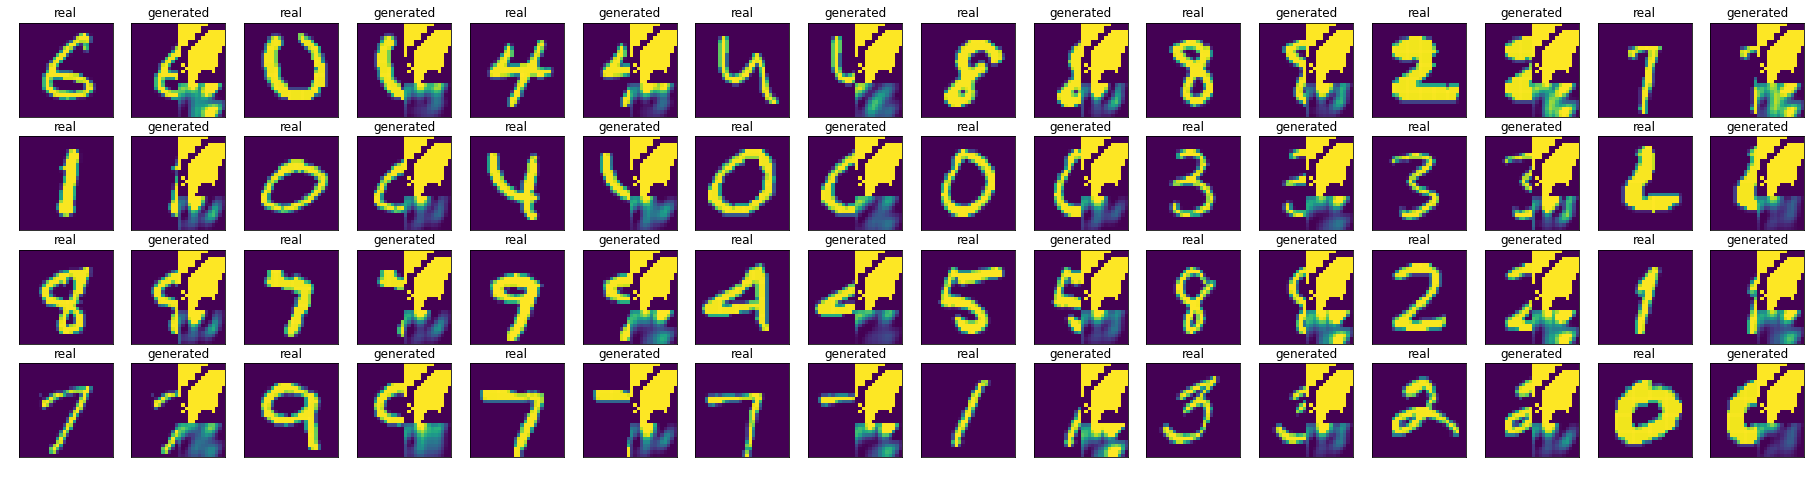

batch size is: 64
Discriminator Loss: 1.2009e+02 and generator loss is: 1.3904e+02
Epoch 7 ended in 6.14 secs.


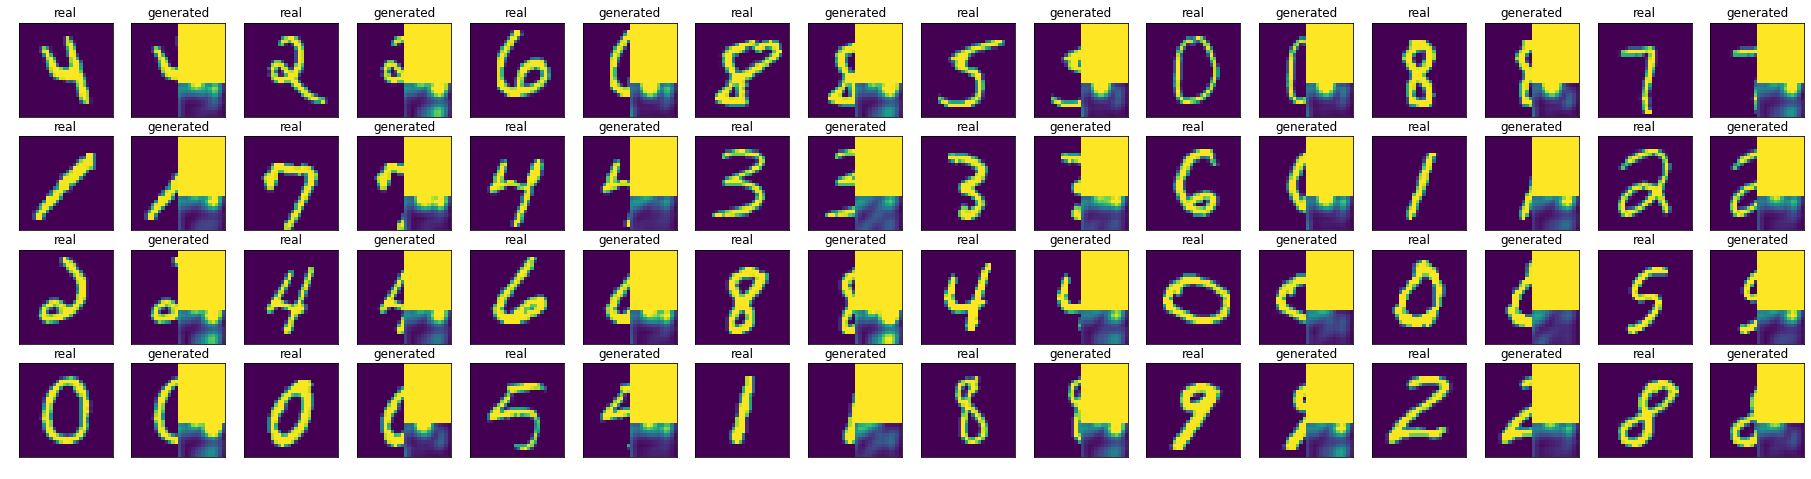

batch size is: 64
Discriminator Loss: 1.2001e+02 and generator loss is: 1.3895e+02
Epoch 8 ended in 6.14 secs.


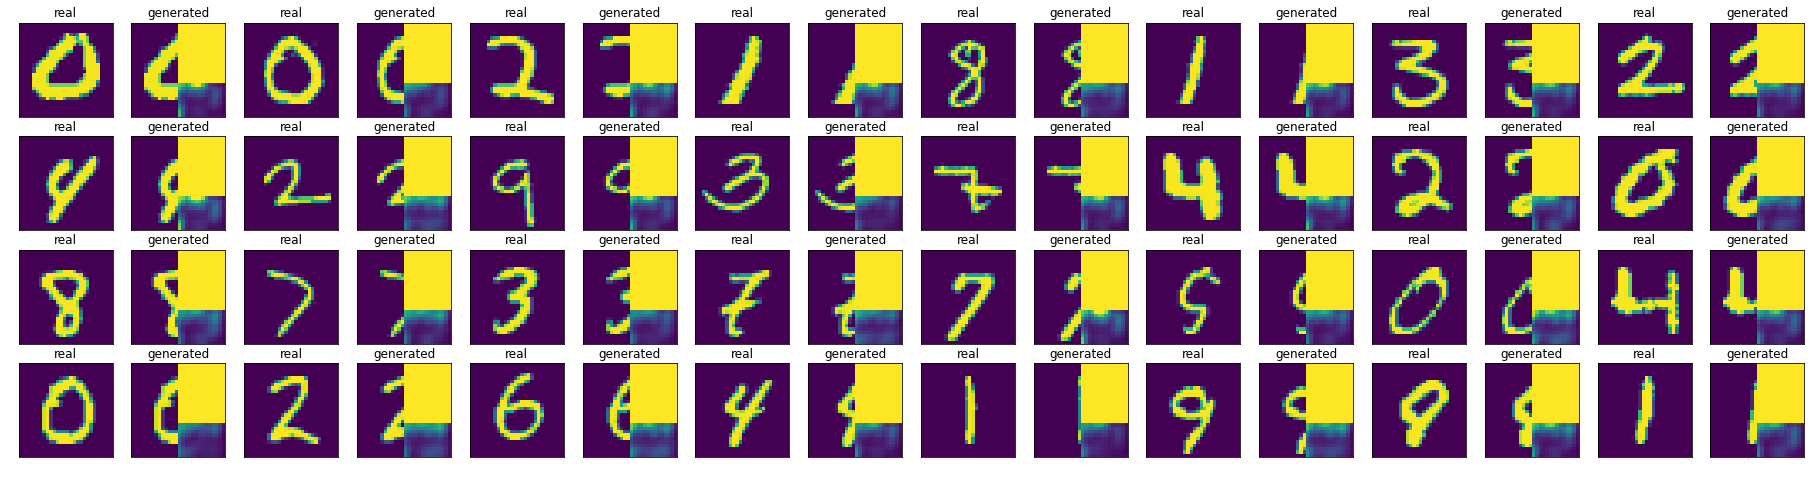

batch size is: 64
Discriminator Loss: 1.1996e+02 and generator loss is: 1.3899e+02
Epoch 9 ended in 6.12 secs.


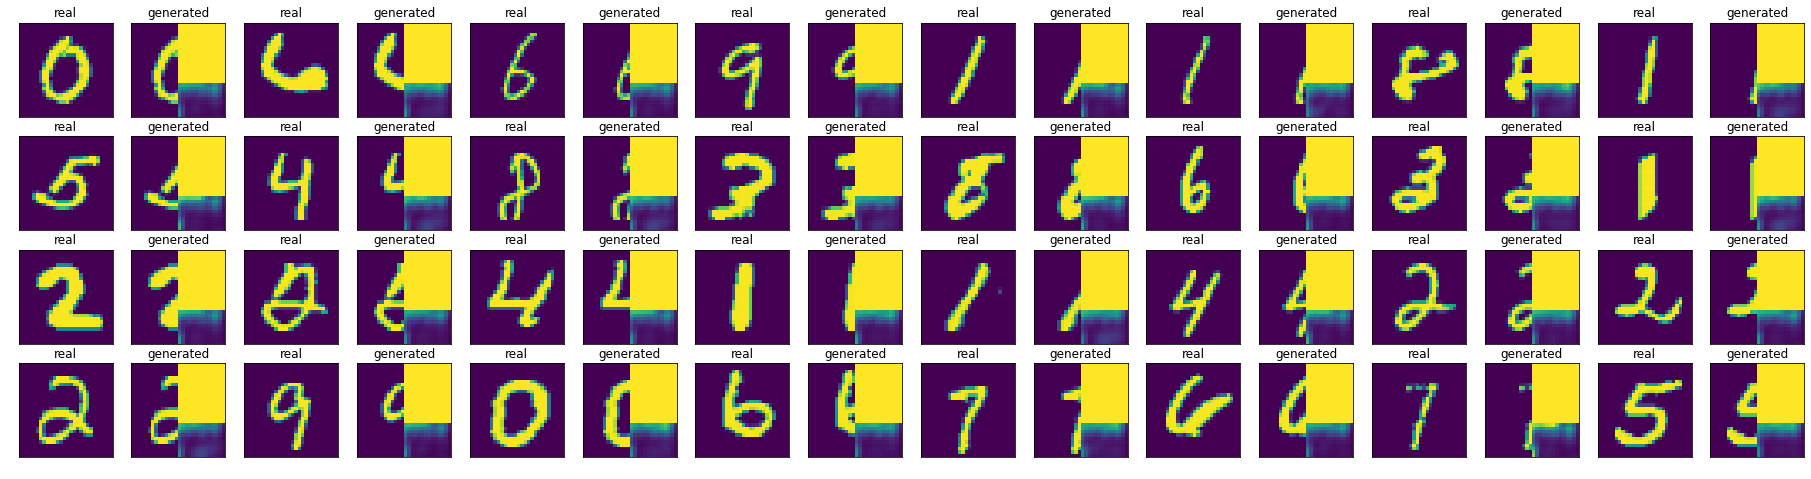

batch size is: 64
Discriminator Loss: 1.2011e+02 and generator loss is: 1.3882e+02
Epoch 10 ended in 6.11 secs.


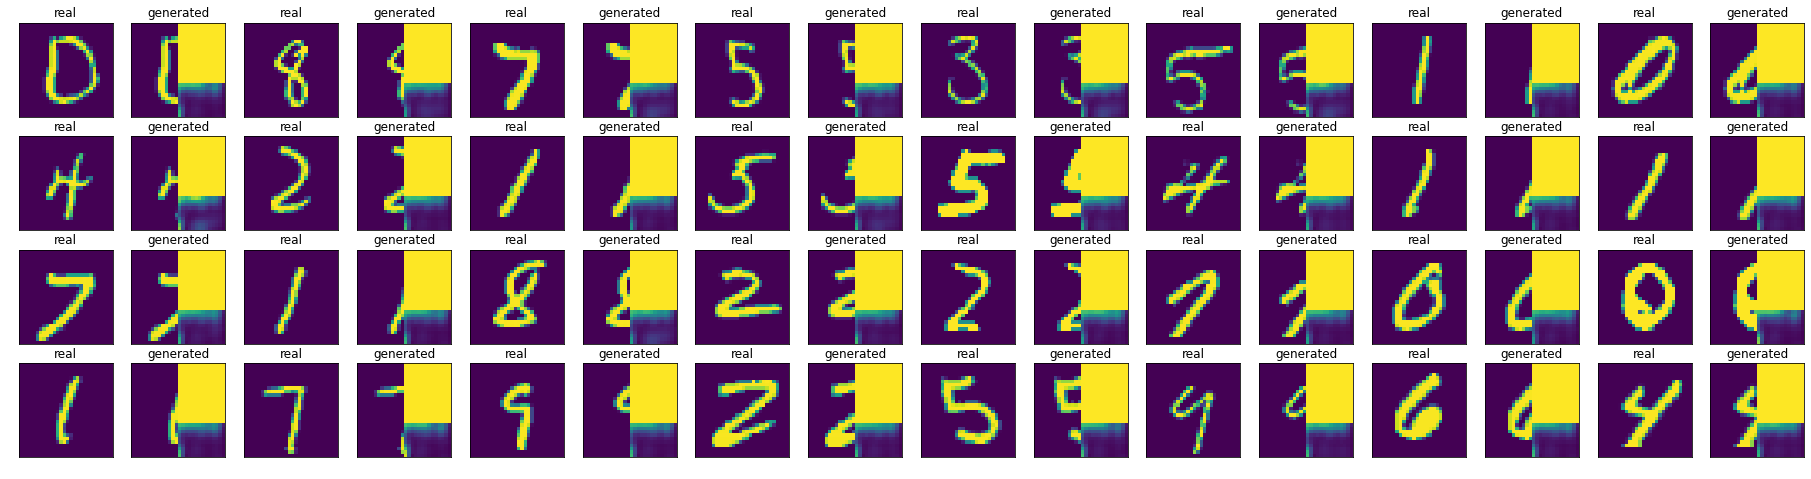

batch size is: 64
Discriminator Loss: 1.1997e+02 and generator loss is: 1.3897e+02
Epoch 11 ended in 6.10 secs.


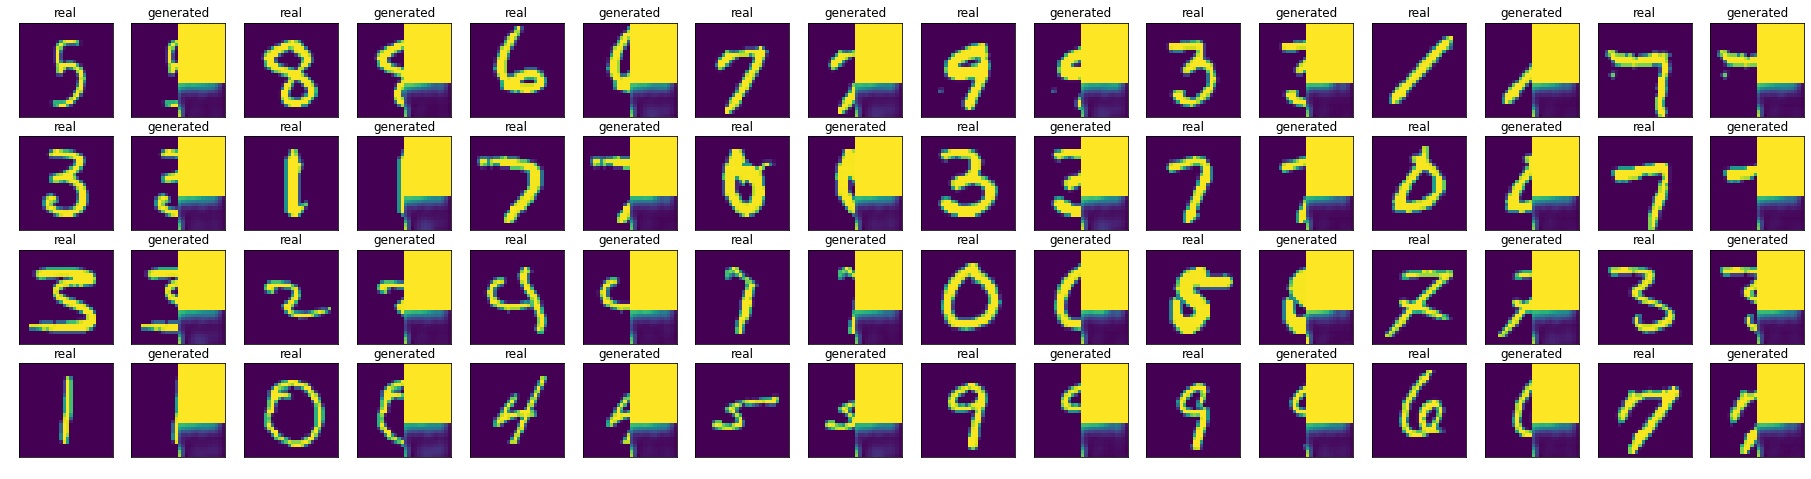

batch size is: 64
Discriminator Loss: 1.2325e+04 and generator loss is: 1.0066e+02
Epoch 12 ended in 6.06 secs.


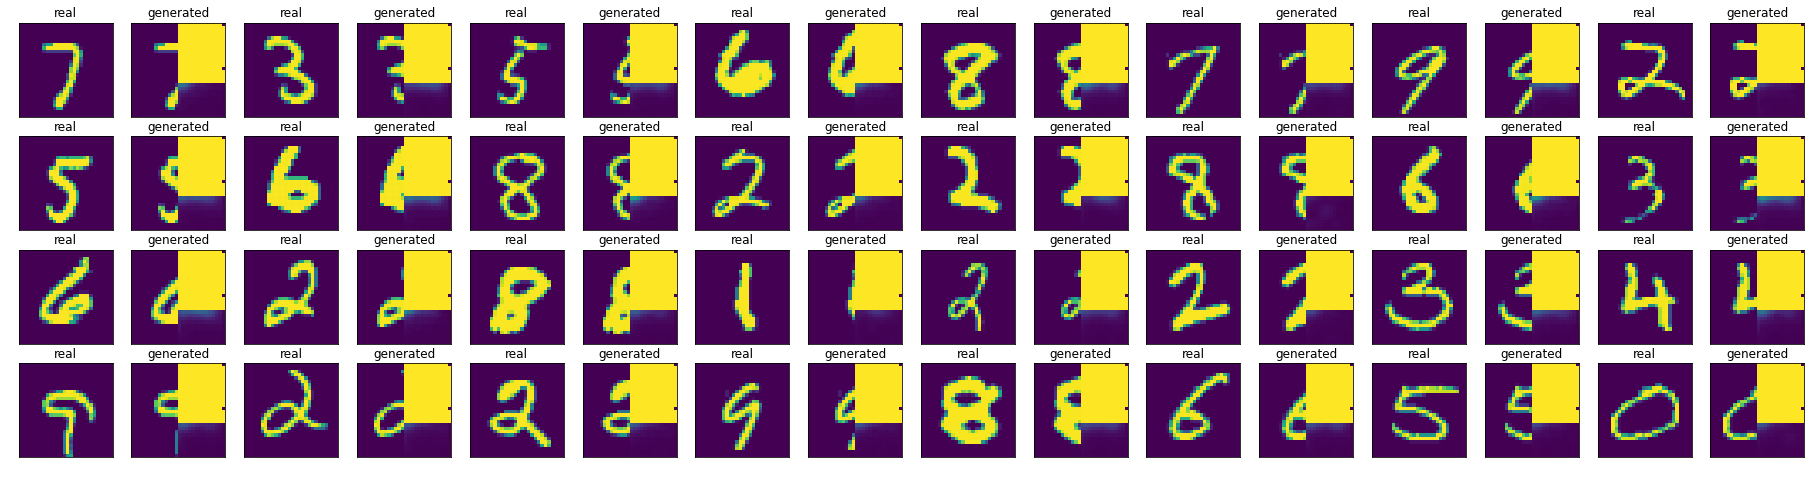

batch size is: 64
Discriminator Loss: 2.2950e+04 and generator loss is: 0.0000e+00
Epoch 13 ended in 6.05 secs.


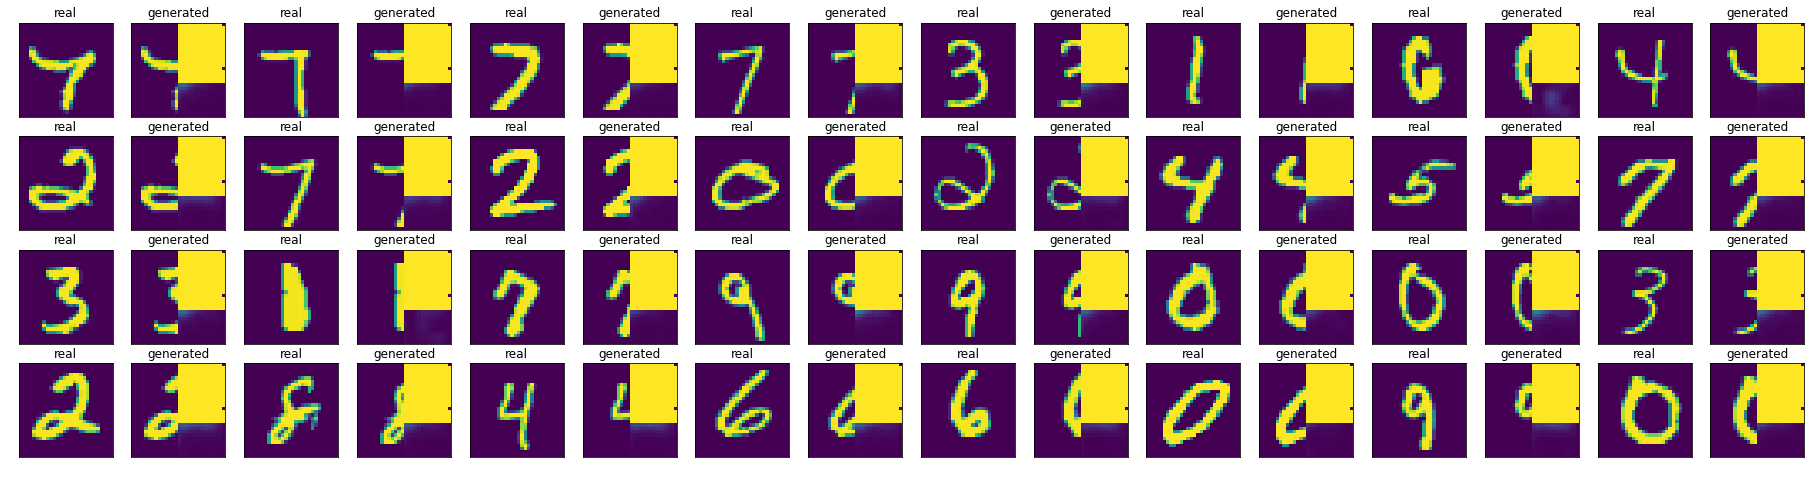

batch size is: 64
Discriminator Loss: 2.2950e+04 and generator loss is: 0.0000e+00
Epoch 14 ended in 6.08 secs.


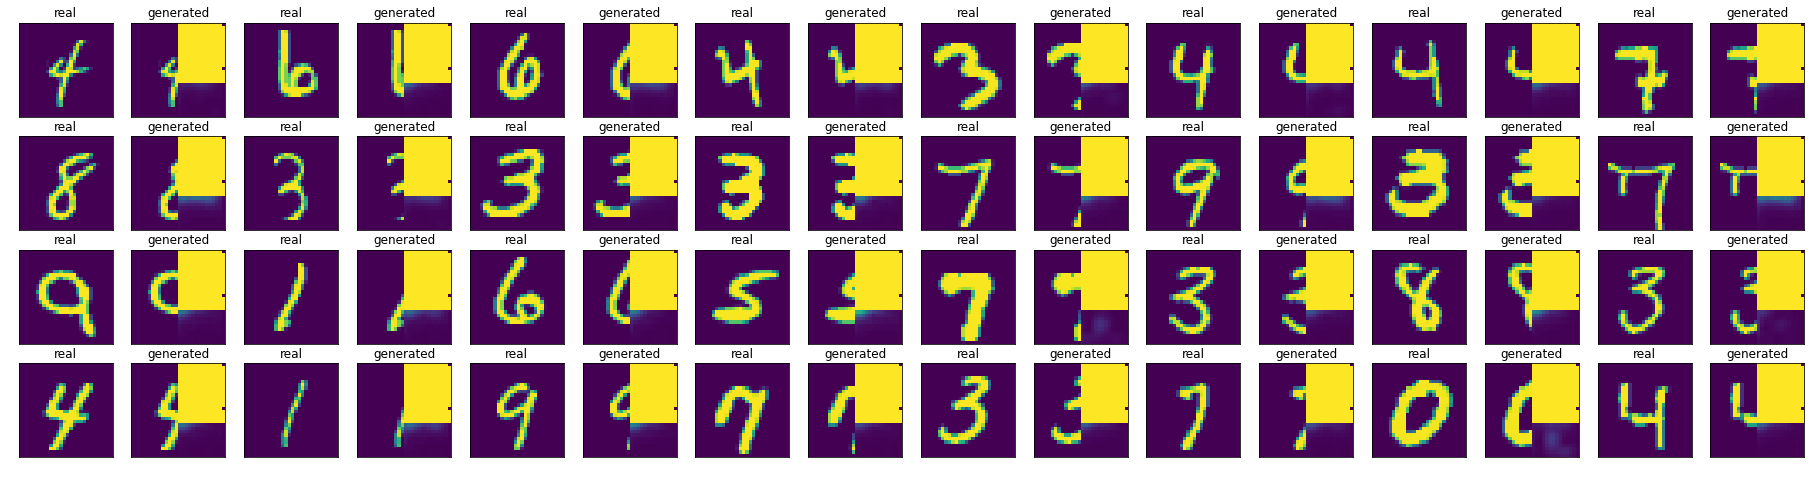

batch size is: 64
Discriminator Loss: 2.2950e+04 and generator loss is: 0.0000e+00
Epoch 15 ended in 6.08 secs.


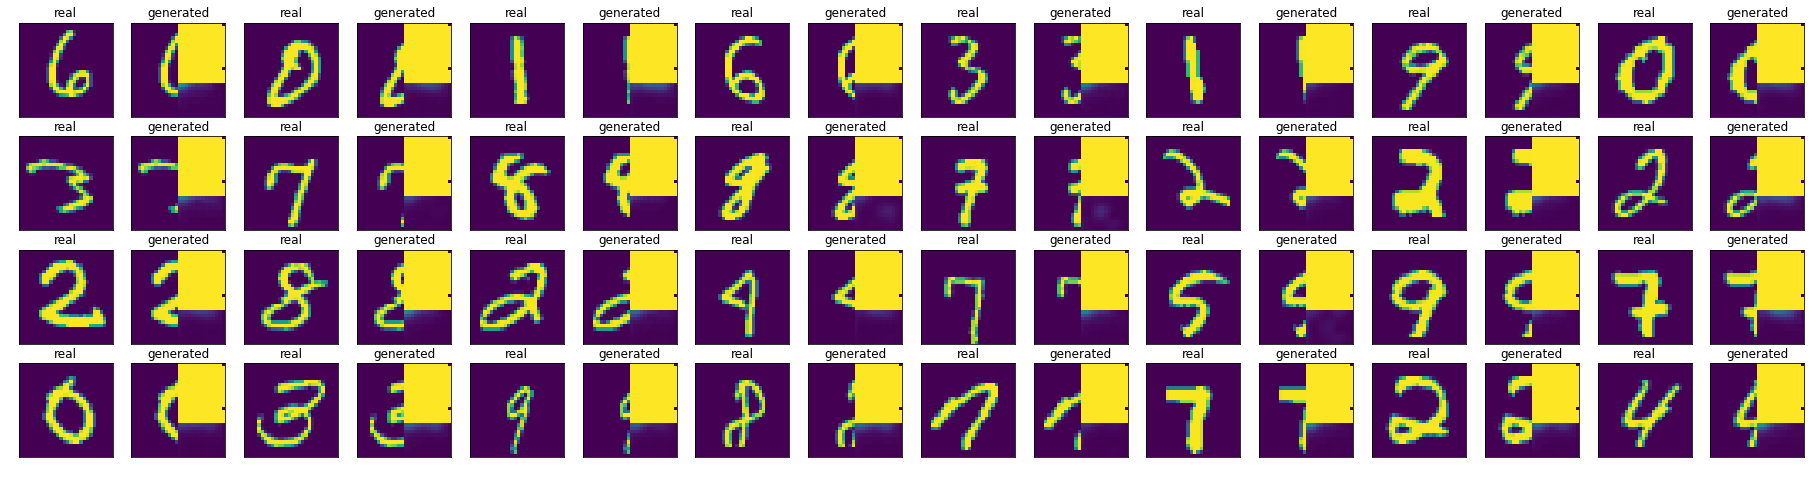

batch size is: 64
Discriminator Loss: 2.2950e+04 and generator loss is: 0.0000e+00
Epoch 16 ended in 6.07 secs.


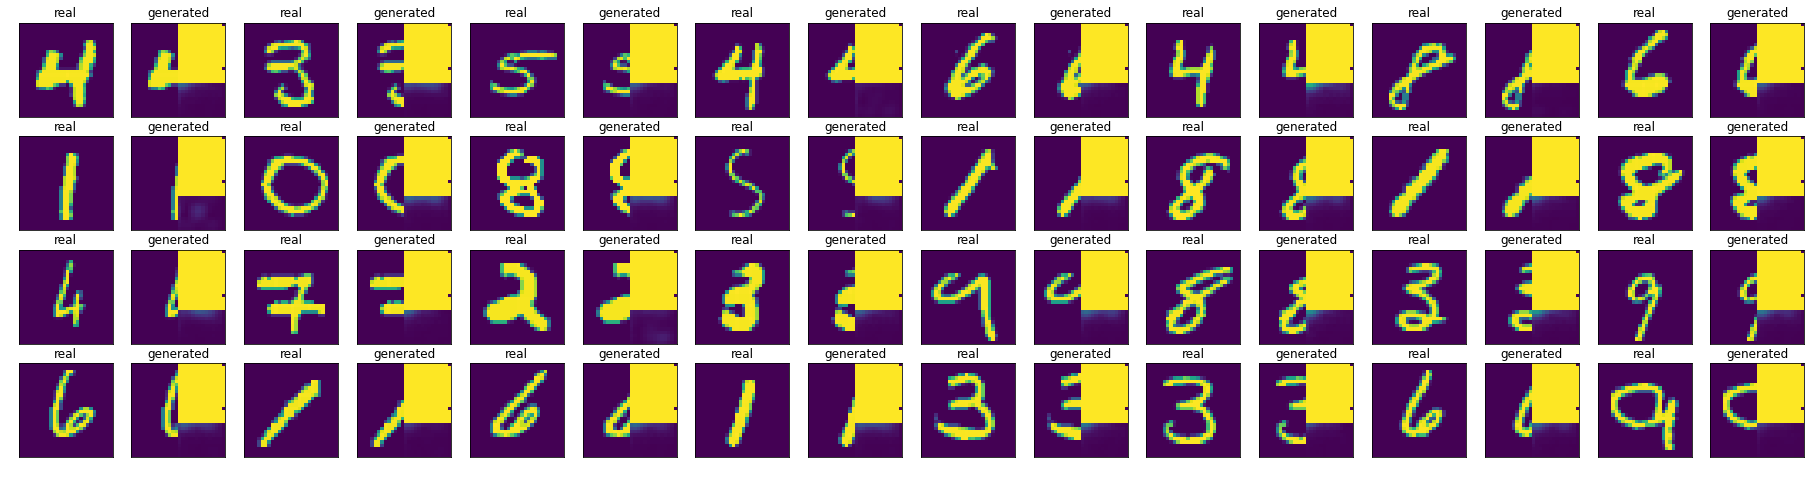

batch size is: 64
Discriminator Loss: 2.2950e+04 and generator loss is: 0.0000e+00
Epoch 17 ended in 6.08 secs.


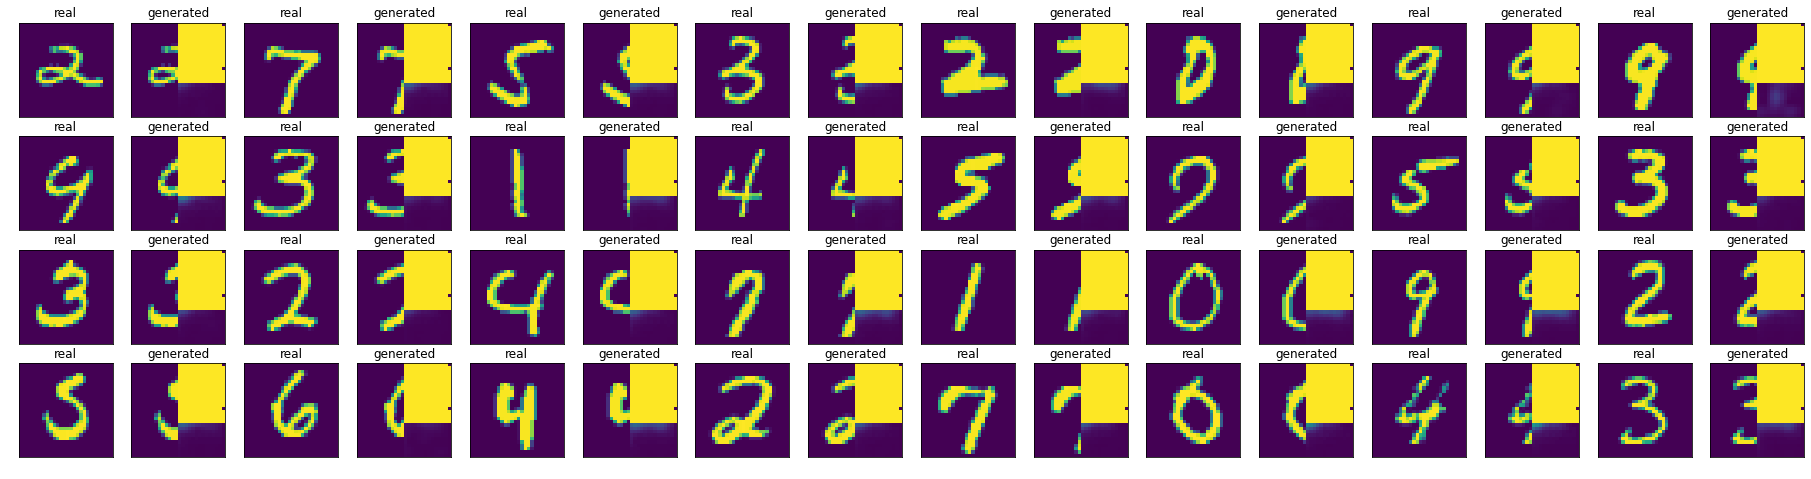

batch size is: 64
Discriminator Loss: 2.2950e+04 and generator loss is: 0.0000e+00
Epoch 18 ended in 6.08 secs.


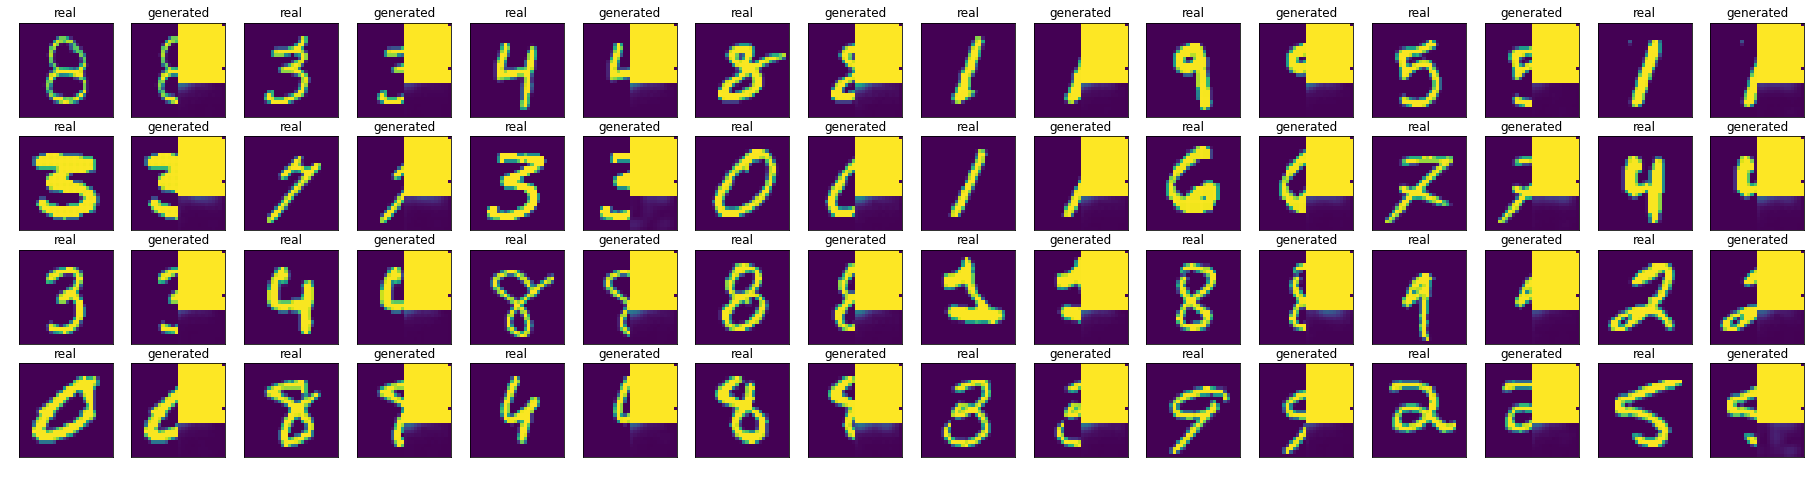

batch size is: 64
Discriminator Loss: 2.2950e+04 and generator loss is: 0.0000e+00
Epoch 19 ended in 6.08 secs.


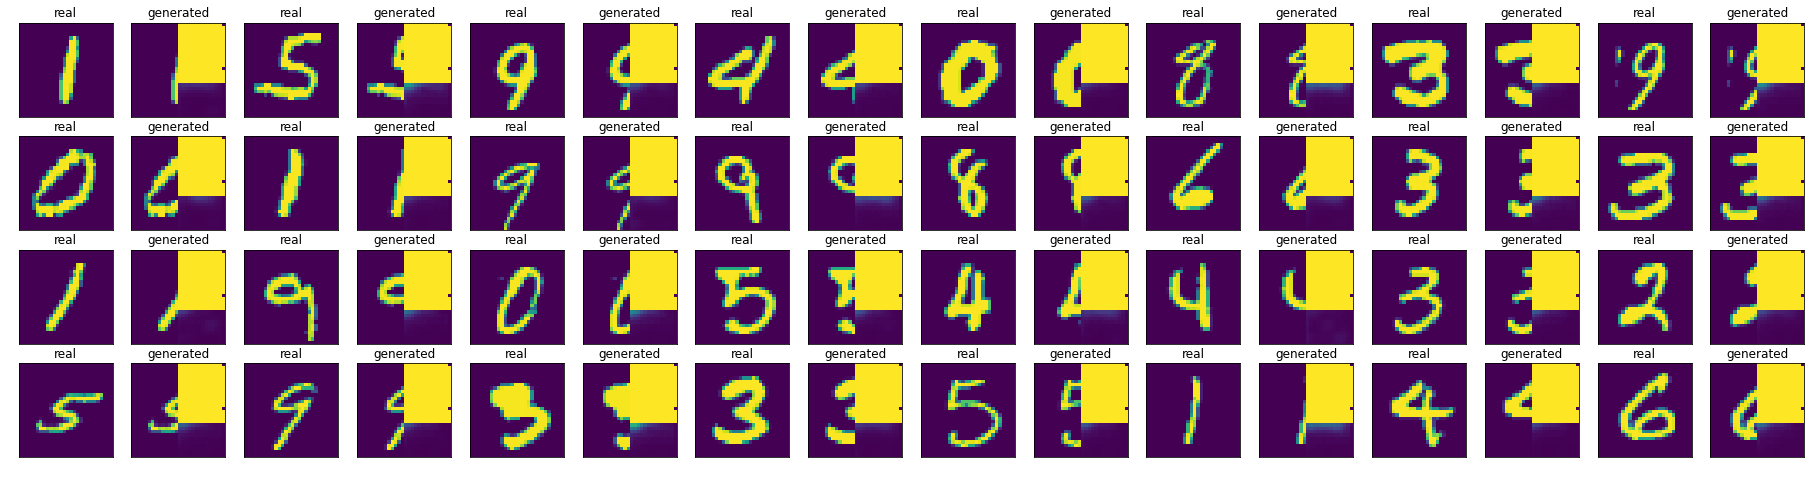

batch size is: 64
Discriminator Loss: 2.2950e+04 and generator loss is: 0.0000e+00
Epoch 20 ended in 6.06 secs.


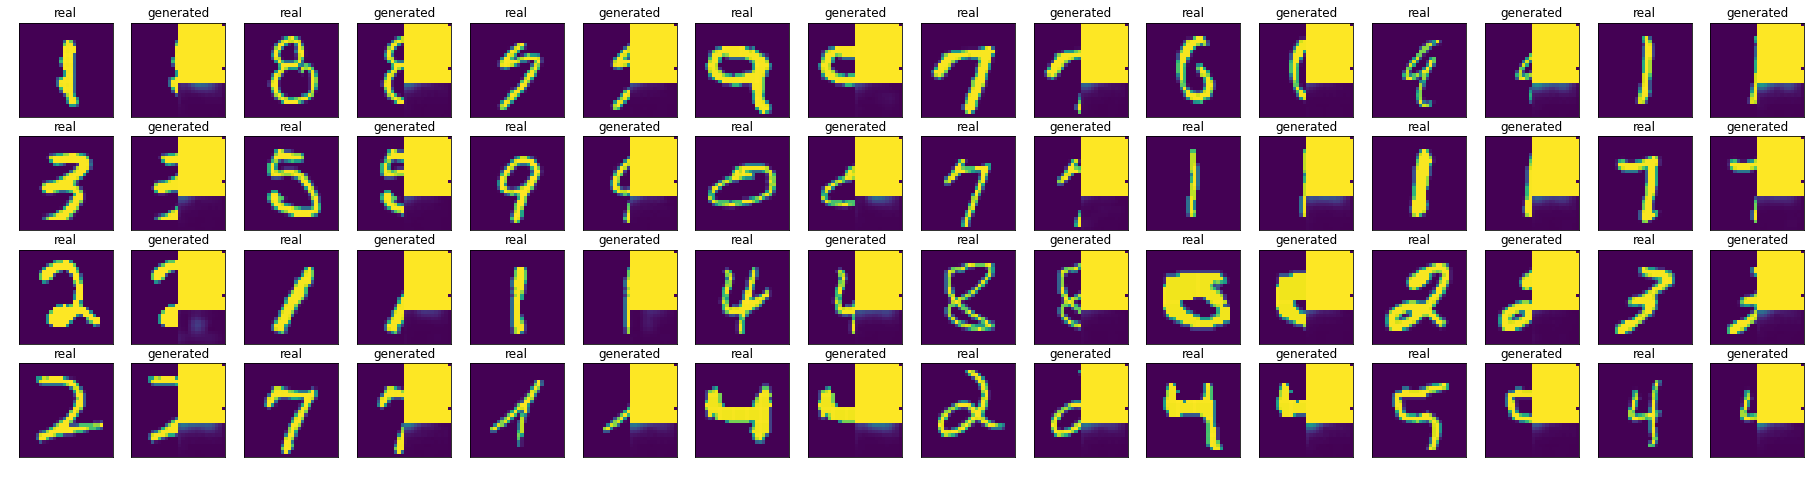

batch size is: 64
Discriminator Loss: 2.2950e+04 and generator loss is: 0.0000e+00
Epoch 21 ended in 6.04 secs.


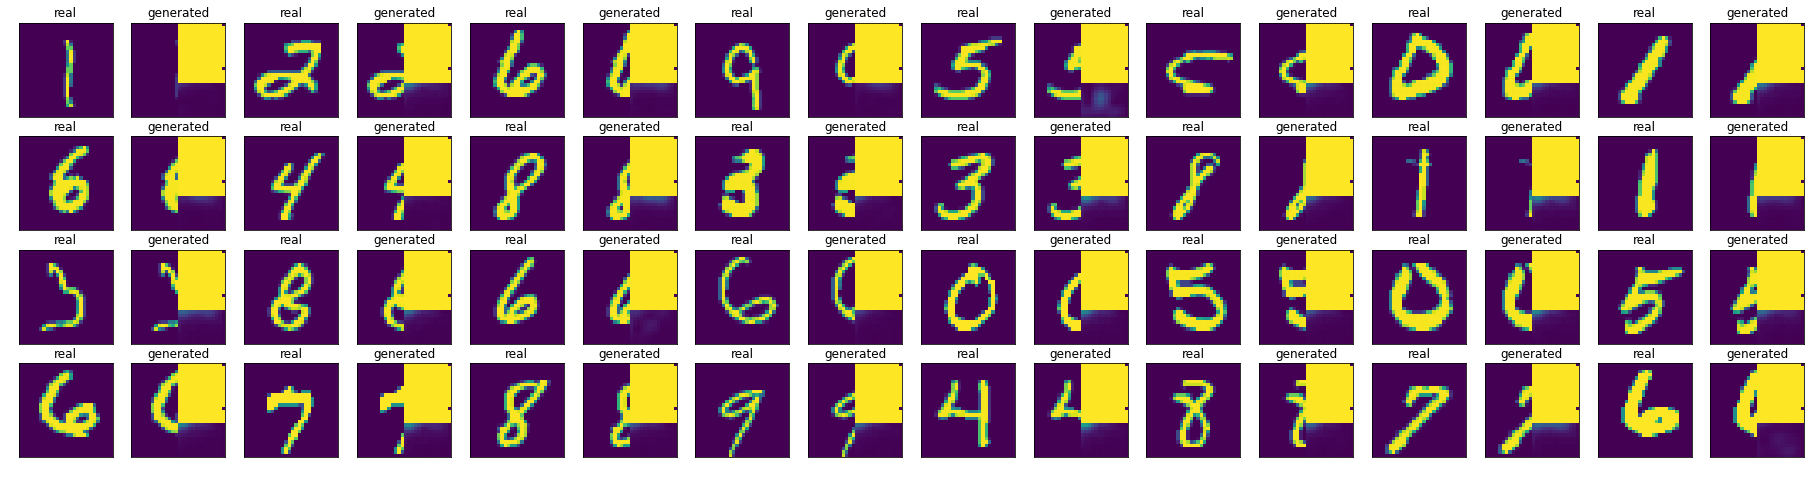

batch size is: 64
Discriminator Loss: 2.2950e+04 and generator loss is: 0.0000e+00
Epoch 22 ended in 6.05 secs.


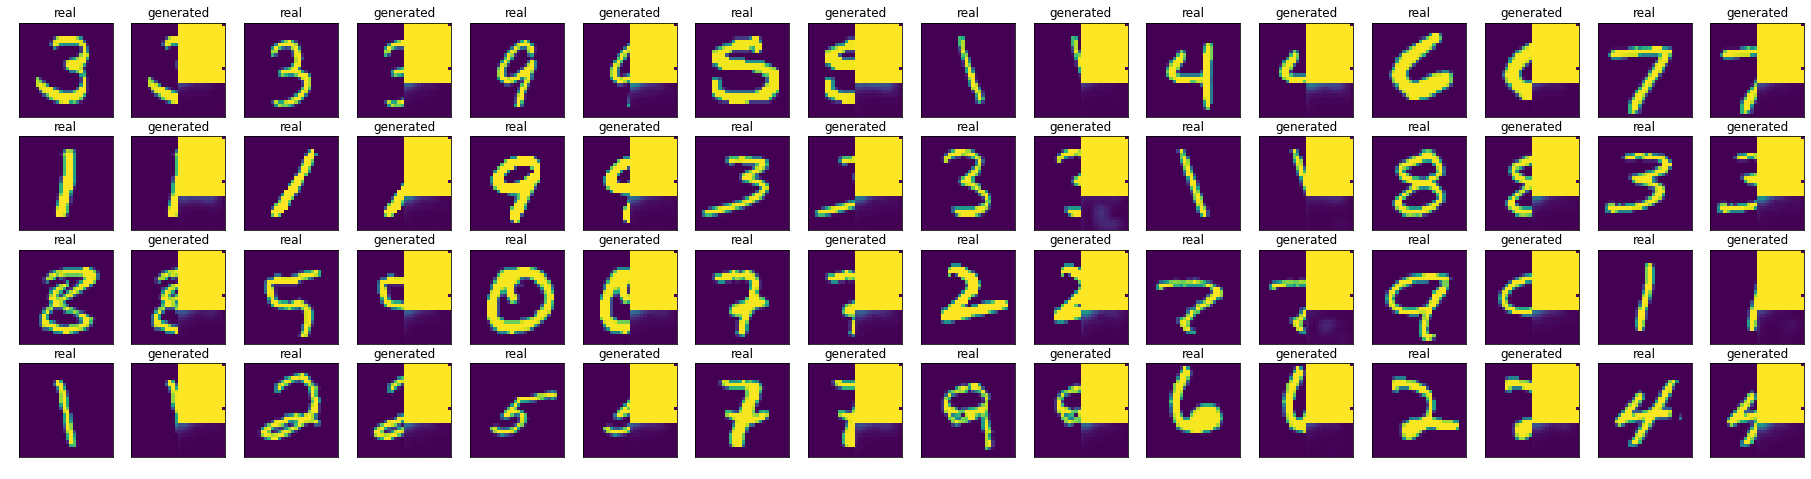

batch size is: 64
Discriminator Loss: 2.2950e+04 and generator loss is: 0.0000e+00
Epoch 23 ended in 6.07 secs.


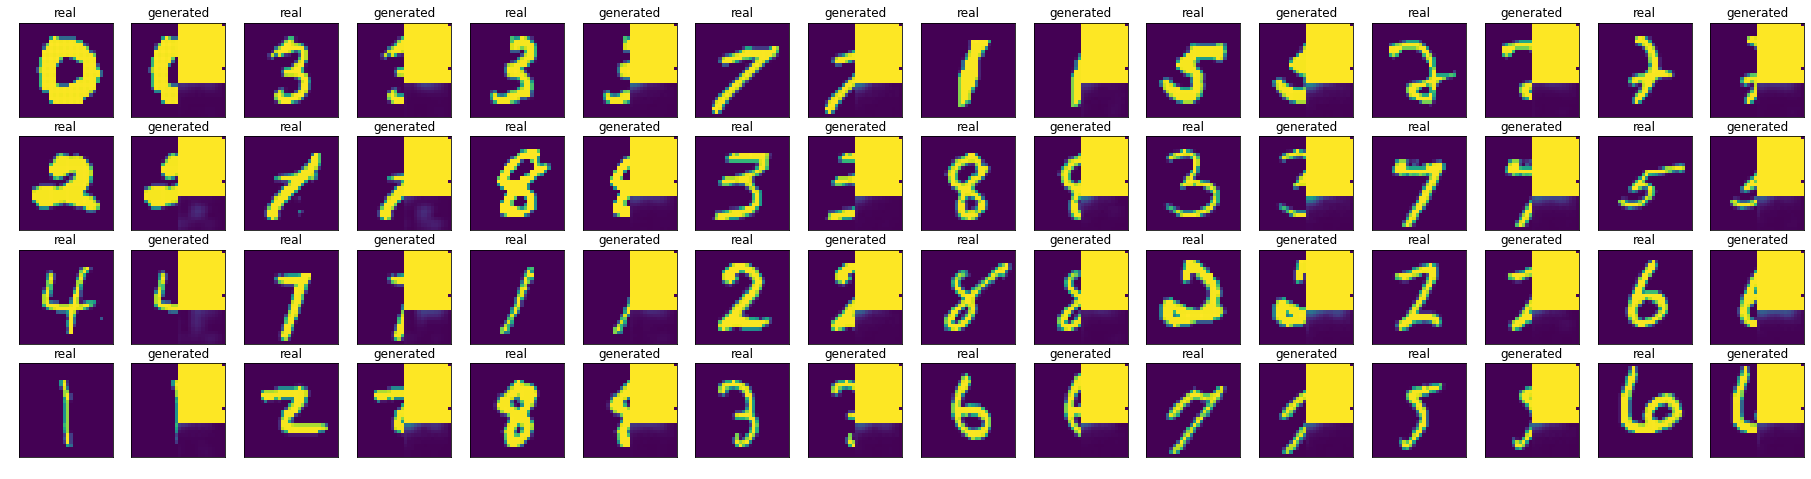

batch size is: 64
Discriminator Loss: 2.2950e+04 and generator loss is: 0.0000e+00
Epoch 24 ended in 6.08 secs.


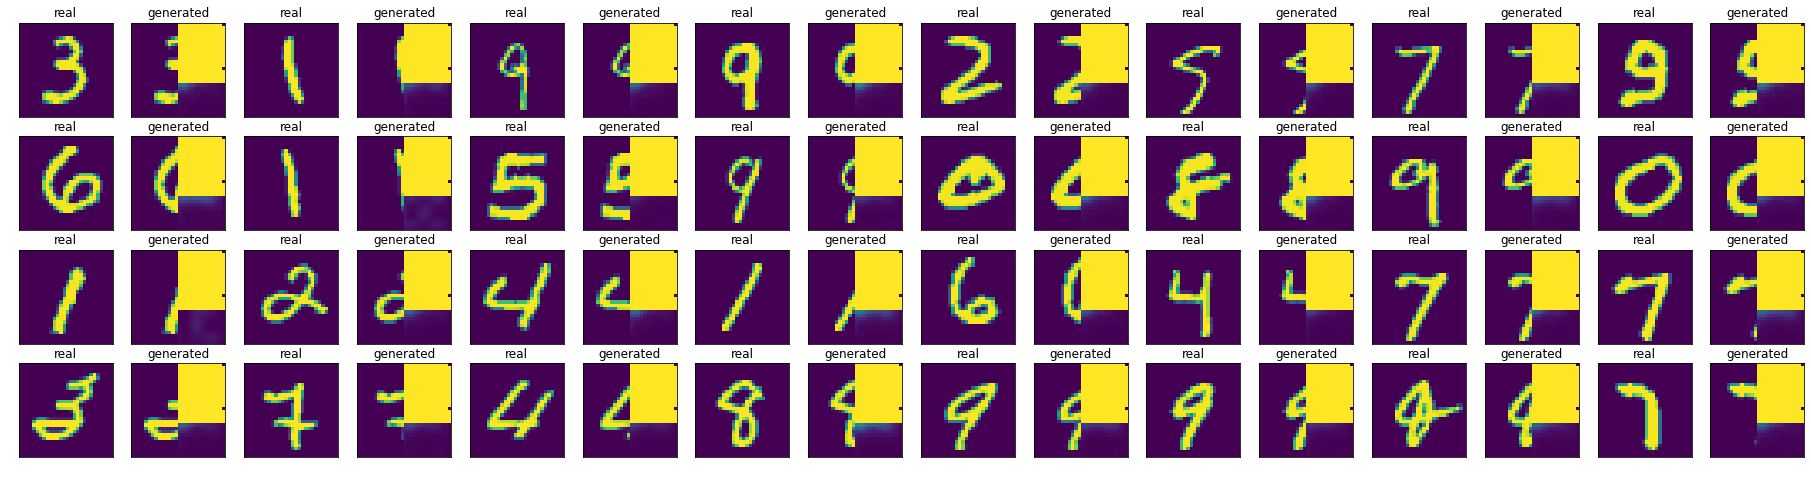

batch size is: 64
Discriminator Loss: 2.2950e+04 and generator loss is: 0.0000e+00
Epoch 25 ended in 6.09 secs.


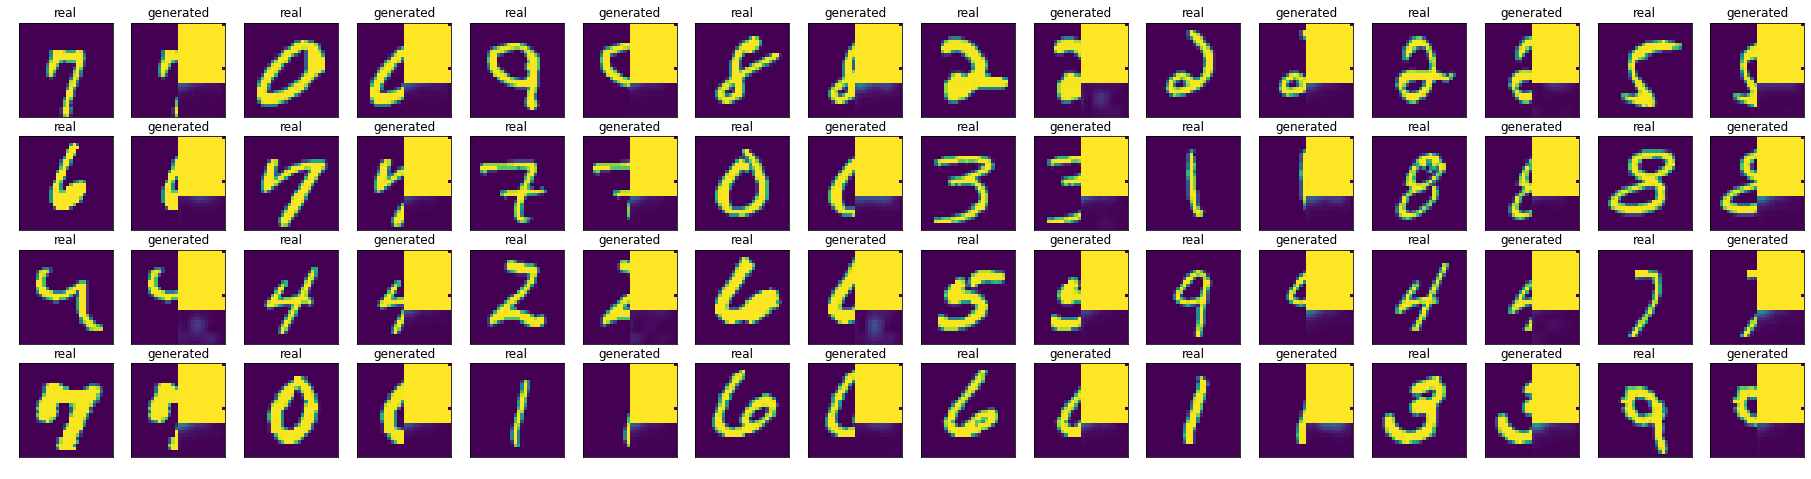

batch size is: 64
Discriminator Loss: 2.2950e+04 and generator loss is: 0.0000e+00
Epoch 26 ended in 6.07 secs.


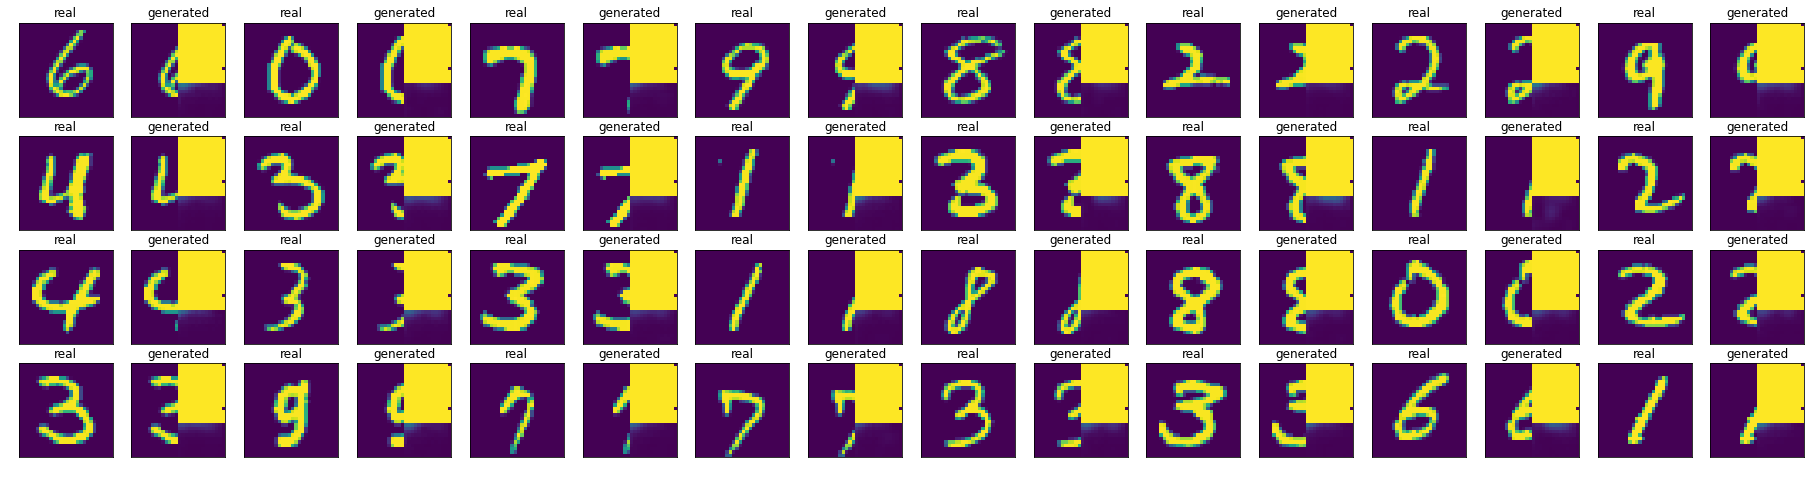

batch size is: 64
Discriminator Loss: 2.2950e+04 and generator loss is: 0.0000e+00
Epoch 27 ended in 6.09 secs.


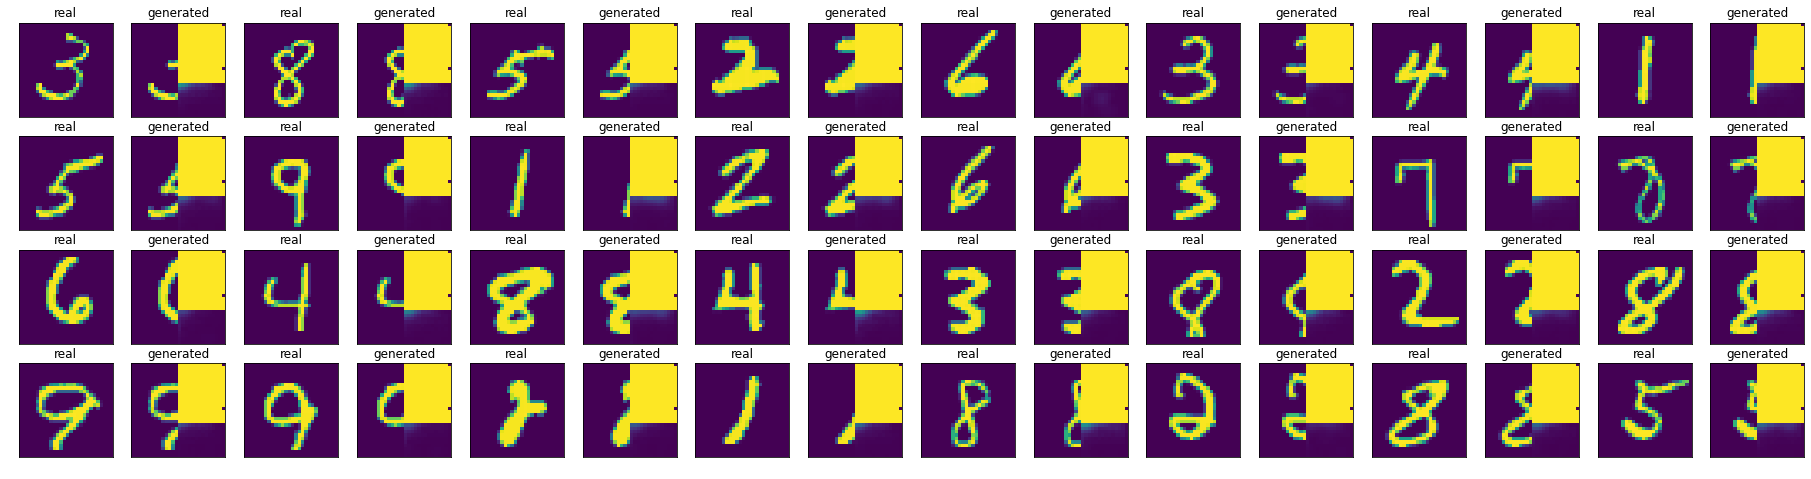

batch size is: 64


KeyboardInterrupt: ignored

In [30]:
iters_per_epoch = int(np.ceil(1.0 * len(x_train) / batch_size))

for e in range(epochs):
    t_start = time()

    inds = np.arange(len(x_train))
    np.random.shuffle(inds)

    epoch_loss = 0
    gen_loss = 0
    # torch.
    print("batch size is:", batch_size)
    # iterating over the whole training set
    for iter in range(iters_per_epoch):

        batch_inds = inds[iter * batch_size: min(len(inds), (iter + 1) * batch_size)]
        batch = x_train[batch_inds]


        if iter % 4 == 0:
            gen_epoch_loss = generator_trainer(generator, discriminator, batch, gen_optimizer, criterion, device)
            gen_loss += float(gen_epoch_loss)
        
        else:      
            loss = discriminator_trainer(criterion, discriminator, batch, device)

            epoch_loss += float(loss)


    print(f'Discriminator Loss: {epoch_loss:.4e} and generator loss is: {gen_loss:.4e}')
    
    print('Epoch %d ended in %.2f secs.' % (e, time() - t_start,))

    display(generator, x_val, 8, 4)